# Homework 2, Problem 4

The goal of this problem is for you to try and classify whether or not an individual is likely to make more or less than 50K per year.  Carry out this task.  Try at least five general architectures, report precision, recall and f1 score on a test set.

For each of the parts, report your preformance in terms not of just numbers but in terms of graphs. When you have training and validation data, please show the curves as the training progresses. You should know when you are overfitting or underfitting. Don't just report bare numbers. **You are free to add implmentation or markdown cells to make your notebook clearer!!**

## Data:

The following dataset was taken from the first dataset repository: http://archive.ics.uci.edu/ml/datasets/Adult

As the original task of the dataset lays out, 
Please note:
* the continuous variable fnlwgt represents final weight, which is the number of units in the target population that the responding unit represents.

## Part 1: Dealing with Missing Values

What should you do about dealing with missing values - do you just drop those rows?  
One of the most common problems we come accross in working with data "in the wild" is missing data. Often we will have observations (rows) that have only some of the needed attributes. Different rows will have different attributes missing. There are a number of strategies for dealing with the missing values. Clearly one could be dropping the column (attribute), or row (observation). Unfortuntely if you drop columns you may lose critical information that is helpful for classification and may be present in most (many) of the rows. You can drop rows but if many rows have at least one missing value, you may loose too much data. Do you try to impute (i. e. fill in) the missing data?  If so how?  

Explain why you chose the strategy you did.

*Hint - '?' denotes a missing value.*

### Some possible strategies for dealing with missing data

1. Whenever there is pleanty of data and very little missing data, you should consider dropping rows and/or columns. This may introduce some bias in the data but again, if the problem is limited to a very few rows or columns, it is easy in training to reproduce.

2. Fill with fixed value using sklearn.impute.SimpleImputer.
    a. 'constant' 0. Rarely a good idea but sometimes, if we can assume that when it is missing it is basically 0, this might be a good idea. For example a data may list number of house fires in a zip code and a missing value just means none.
    b. 'mean' if the data is numeric, the mean is meaningfull.
    c. 'median' may be more sensible if the data is integer or ordered. When the mean and median are very different it is important to understand what a "typical" example might mean. When considering "income", for example, a few large outliers will mess up the mean.
    d. "most_frequent' when you have categorical (nominal) labels, mean and median don't make any sense. Most probable label is what you need to use. This is also known as "mode".

3. sklearn.impute.MissingIndicator: Sometimes the fact that a value is missing, is itself an important indicator. One can create a new feature/attribute that indicates a certain attribute is missing. If you later build a classifier by hand you can explicitly wieght each variable using the missing variable weights so that for that example (row) that attribute won't contribute to the classifier. In a deep neural network it is possible that the network can learn to do that automatically.

4. One can use the sklearn.impute.KNNImputer which will look for rows to fill in the data.

5. Fill with sklearn.impute.IterativeImputer scikit-learn provides a sophisticated imputation strategy. You can read up on this in the documentation, but it will fix on of the columns (attributes), and try to use the other features to predict similar to KNN but more sophisticated.

6. Train a classifier: You can build your own classifier using machine learning. This is kind of a problem within a problem but if done correctly, it has the potential to be more accurate than a simpler method. Of course, if done badly it could be worse.

7. Manually impute the missing values. You may know enough about the problem to build an ad-hoc way to fill in the missing values for each column in a way that makes the most sense. This almost always requires a great deal of domain expertise. 



In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,precision_score,f1_score,recall_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [0]:
# Add your code for filling in the data here. Please end by using the appropriate bandas method
# to show the amount of missing data (which in the end should not be any since you dropped or filled in data)


import pandas as pd

columns = [
    "age",
    "work_class",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "target"
]
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/adult.data", names=columns)
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].str.strip()

In [5]:
df.head()

,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


##### Check for columns with missing values

In [6]:
print(df.isin(['?']).any())

age               False
work_class         True
fnlwgt            False
education         False
education_num     False
marital_status    False
occupation         True
relationship      False
race              False
sex               False
capital_gain      False
capital_loss      False
hours_per_week    False
native_country     True
target            False
dtype: bool


In [7]:
df.isnull().any()

age               False
work_class        False
fnlwgt            False
education         False
education_num     False
marital_status    False
occupation        False
relationship      False
race              False
sex               False
capital_gain      False
capital_loss      False
hours_per_week    False
native_country    False
target            False
dtype: bool

##### Clean up

In [0]:
# Drop relationship because it's overlapping with marital status and sex
df.drop(['relationship',],axis=1,inplace=True)

In [0]:
# Also drop 'fnlwgt' because it seems irrelevant in the prediction task
df.drop(['fnlwgt',],axis=1,inplace=True)

In [0]:
# Also drop 'education' because it's overlapping with 'education_num'
df.drop(['education',],axis=1,inplace=True)

In [11]:
df['marital_status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [12]:
df['work_class'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [13]:
df['native_country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [0]:
# Since there are too many countries, which will make it harder to encode later, we need to transform it to US or non-US
df['native_country'] = df['native_country'].apply(lambda c: 'US' if c == 'United-States' else 'non-US')

In [15]:
df['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [0]:
# Replace missing value with the most frequent values 
imp = SimpleImputer(missing_values='?', strategy='most_frequent')
df = pd.DataFrame(imp.fit_transform(df),
                   columns=df.columns,
                   index=df.index)

In [0]:
# To make it easier to classify (binary) later, transforming the target column to 0 if income is smaller than 50K, and to 1 if income is equal or more than 50K
df['target'] = df['target'].apply(lambda c: 0 if c == '<=50K' else 1)

In [18]:
df.head()

,age,work_class,education_num,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,13,Never-married,Adm-clerical,White,Male,2174,0,40,US,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,US,0
2,38,Private,9,Divorced,Handlers-cleaners,White,Male,0,0,40,US,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,US,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,non-US,0


## Part 2: Train Test Validate Split

Ideally you will split the data and use the train data filling in proceedure for the test data. Because this is expensive you can do experiments initially to see if this matters. Just keep carefully in mind what you will know and what you can't know during the test evaluation. Both sklearn and tensorflow provide facilities for train test split. Take your pick.

At the end of this you should have a train, validate and test split. In the next part you are going to do preliminary testing of your model with your train+validation sets to get some idea of good canditates for hyperparameters. Later you will merge your training and validation set and resplit them up using cross validation to get better estimates for setting hyper-parameters

**NOTE: It is very important that you record very carefully any parameters you have for filling in data in step 1. For example if you you build a "fit" using some training data, later you will need to use the this "fit" to transform the data, you can not re-fit on new data. In other words if your "pipline" in training takes the mean of the input to fill in the first column, you need to fill with exactly that number, when you get new data for testing. Don't take the mean of the test data.**

In [0]:
# Fill your solution for a train-test split in here.
y = np.array(df['target'])
X = pd.get_dummies(df.drop(['target'], axis=1)).values

In [20]:
X.shape

(32561, 432)

In [21]:
y.shape

(32561,)

In [0]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Part 3: Build different 2 sklearn models and five different variations of Keras/tensorflow  models

Two simple models should be baseline from sklearn. Try a logistic regression and a random forest to know what your dense neural network should be able to beat. Use the training and validation data from above (don't look at the testing data). Try varations on the number of notes in a layer, the number of layers. Also play with feature selection. You can try to eliminate featuers and see if your validation score goes up or down. See how the batch size effects things.

### At the end of this section provide a report with figures on your conclusion on how these things effected preformance:

* number of hidden layers
* number of nodes per hidden layer aka matrix dimension
* activation function
* weight initialization
* metrics for evaluation
* batch size
* number of epochs
* optimizer
* also carry out feature selection / dimensionality reduction
* does the model do better or worse with dimensionality reduction?

** Note: do not try regularization yet!*


In [23]:
# Get baseline results here with logisic regression and random forest
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test,y_pred_lr))

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4942
           1       0.79      0.65      0.71      1571

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4942
           1       0.74      0.62      0.67      1571

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.85      0.85      6513



In [0]:
# Set up your models here
def model_one():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(1,activation='linear'))
  model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])
  
  return model

def model_two():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])
  
  return model

def model_three():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])
  
  return model

def model_four():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])
  
  return model

def model_five():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dense(8, activation = 'relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])

  return model

# Perform preliminary evaluations here

In [0]:
model_1, model_2, model_3, model_4, model_5 = model_one(), model_two(), model_three(), model_four(), model_five()

In [0]:
models = []
models.extend([model_1, model_2, model_3, model_4, model_5])

Train on 20838 samples, validate on 5210 samples
Epoch 1/10
20838/20838 [==============================] - 1s 50us/step - loss: 0.3950 - accuracy: 0.8298 - val_loss: 0.3683 - val_accuracy: 0.8334
Epoch 2/10
20838/20838 [==============================] - 1s 46us/step - loss: 0.3523 - accuracy: 0.8116 - val_loss: 0.3474 - val_accuracy: 0.8242
Epoch 3/10
20838/20838 [==============================] - 1s 46us/step - loss: 0.3403 - accuracy: 0.7898 - val_loss: 0.3587 - val_accuracy: 0.7670
Epoch 4/10
20838/20838 [==============================] - 1s 46us/step - loss: 0.3196 - accuracy: 0.7586 - val_loss: 0.3359 - val_accuracy: 0.7716
Epoch 5/10
20838/20838 [==============================] - 1s 47us/step - loss: 0.3086 - accuracy: 0.7317 - val_loss: 0.3830 - val_accuracy: 0.7315
Epoch 6/10
20838/20838 [==============================] - 1s 46us/step - loss: 0.3092 - accuracy: 0.7181 - val_loss: 0.3501 - val_accuracy: 0.6952
Epoch 7/10
20838/20838 [==============================] - 1s 46us/ste

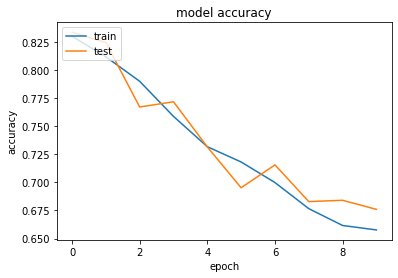

Train on 20838 samples, validate on 5210 samples
Epoch 1/10
20838/20838 [==============================] - 1s 49us/step - loss: 0.3542 - accuracy: 0.8353 - val_loss: 0.2993 - val_accuracy: 0.8628
Epoch 2/10
20838/20838 [==============================] - 1s 46us/step - loss: 0.2958 - accuracy: 0.8634 - val_loss: 0.2838 - val_accuracy: 0.8676
Epoch 3/10
20838/20838 [==============================] - 1s 45us/step - loss: 0.2839 - accuracy: 0.8698 - val_loss: 0.2797 - val_accuracy: 0.8699
Epoch 4/10
20838/20838 [==============================] - 1s 45us/step - loss: 0.2770 - accuracy: 0.8707 - val_loss: 0.2734 - val_accuracy: 0.8729
Epoch 5/10
20838/20838 [==============================] - 1s 46us/step - loss: 0.2713 - accuracy: 0.8738 - val_loss: 0.2711 - val_accuracy: 0.8716
Epoch 6/10
20838/20838 [==============================] - 1s 44us/step - loss: 0.2668 - accuracy: 0.8755 - val_loss: 0.2712 - val_accuracy: 0.8702
Epoch 7/10
20838/20838 [==============================] - 1s 48us/ste

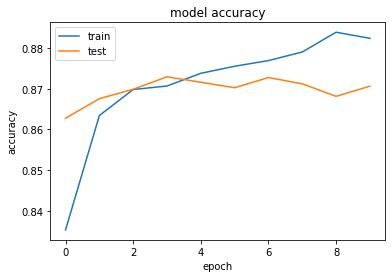

Train on 20838 samples, validate on 5210 samples
Epoch 1/10
20838/20838 [==============================] - 1s 53us/step - loss: 0.3436 - accuracy: 0.8411 - val_loss: 0.2974 - val_accuracy: 0.8649
Epoch 2/10
20838/20838 [==============================] - 1s 52us/step - loss: 0.2897 - accuracy: 0.8673 - val_loss: 0.2759 - val_accuracy: 0.8745
Epoch 3/10
20838/20838 [==============================] - 1s 48us/step - loss: 0.2761 - accuracy: 0.8743 - val_loss: 0.2752 - val_accuracy: 0.8689
Epoch 4/10
20838/20838 [==============================] - 1s 48us/step - loss: 0.2665 - accuracy: 0.8772 - val_loss: 0.2772 - val_accuracy: 0.8674
Epoch 5/10
20838/20838 [==============================] - 1s 48us/step - loss: 0.2596 - accuracy: 0.8789 - val_loss: 0.2757 - val_accuracy: 0.8712
Epoch 6/10
20838/20838 [==============================] - 1s 47us/step - loss: 0.2502 - accuracy: 0.8831 - val_loss: 0.2961 - val_accuracy: 0.8689
Epoch 7/10
20838/20838 [==============================] - 1s 50us/ste

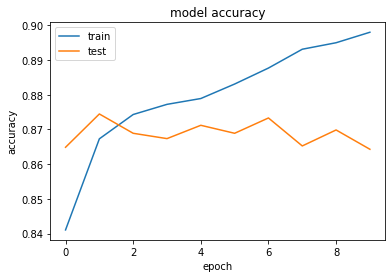

Train on 20838 samples, validate on 5210 samples
Epoch 1/10
20838/20838 [==============================] - 1s 53us/step - loss: 0.3433 - accuracy: 0.8412 - val_loss: 0.2931 - val_accuracy: 0.8655
Epoch 2/10
20838/20838 [==============================] - 1s 48us/step - loss: 0.2886 - accuracy: 0.8667 - val_loss: 0.2790 - val_accuracy: 0.8672
Epoch 3/10
20838/20838 [==============================] - 1s 51us/step - loss: 0.2737 - accuracy: 0.8725 - val_loss: 0.2951 - val_accuracy: 0.8599
Epoch 4/10
20838/20838 [==============================] - 1s 50us/step - loss: 0.2644 - accuracy: 0.8772 - val_loss: 0.2758 - val_accuracy: 0.8706
Epoch 5/10
20838/20838 [==============================] - 1s 48us/step - loss: 0.2549 - accuracy: 0.8807 - val_loss: 0.2790 - val_accuracy: 0.8699
Epoch 6/10
20838/20838 [==============================] - 1s 48us/step - loss: 0.2454 - accuracy: 0.8870 - val_loss: 0.2872 - val_accuracy: 0.8666
Epoch 7/10
20838/20838 [==============================] - 1s 49us/ste

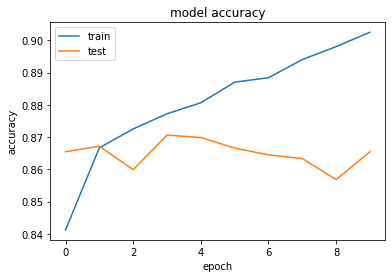

Train on 20838 samples, validate on 5210 samples
Epoch 1/10
20838/20838 [==============================] - 1s 56us/step - loss: 0.3450 - accuracy: 0.8413 - val_loss: 0.2906 - val_accuracy: 0.8660
Epoch 2/10
20838/20838 [==============================] - 1s 54us/step - loss: 0.2898 - accuracy: 0.8659 - val_loss: 0.2762 - val_accuracy: 0.8716
Epoch 3/10
20838/20838 [==============================] - 1s 52us/step - loss: 0.2775 - accuracy: 0.8711 - val_loss: 0.2745 - val_accuracy: 0.8710
Epoch 4/10
20838/20838 [==============================] - 1s 53us/step - loss: 0.2674 - accuracy: 0.8757 - val_loss: 0.2726 - val_accuracy: 0.8724
Epoch 5/10
20838/20838 [==============================] - 1s 54us/step - loss: 0.2600 - accuracy: 0.8791 - val_loss: 0.2749 - val_accuracy: 0.8745
Epoch 6/10
20838/20838 [==============================] - 1s 58us/step - loss: 0.2525 - accuracy: 0.8807 - val_loss: 0.2782 - val_accuracy: 0.8735
Epoch 7/10
20838/20838 [==============================] - 1s 53us/ste

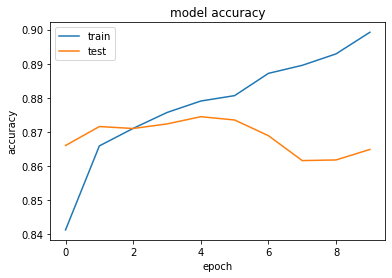

In [51]:
for model in models:
    history = model.fit(X_train, y_train, batch_size=32, validation_split = 0.2 ,epochs=10)
    model.evaluate(X_test, y_test, batch_size=16)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Part 4: Cross-validation
We really should have used k-fold (eg. k=5) crossvalidation here, to not only evaluate our five keras/tensorflow models. See how your preliminary results change. Now that we have validation results with uncertainy (+- standard deviation), do your prior conclusion change. 

In [52]:
# Part 4 inplement cross validation here
kf = KFold(n_splits=5,random_state= 42)

for train_idx, test_idx in kf.split(X_train):
    X_train_kf, X_test_kf = X_train[train_idx], X_train[test_idx]
    y_train_kf, y_test_kf = y_train[train_idx], y_train[test_idx]

    for i, model in enumerate(models):
        print(f"Evaluating model {i}")
        model.fit(X_train_kf, y_train_kf, batch_size=32, epochs=10)
        model.evaluate(X_test_kf, y_test_kf, batch_size=16)

Evaluating model 0
Epoch 1/10
 3616/20838 [====>.........................] - ETA: 0s - loss: 0.3183 - accuracy: 0.6419

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


20838/20838 [==============================] - 1s 45us/step - loss: 0.3132 - accuracy: 0.6769
Epoch 2/10
20838/20838 [==============================] - 1s 40us/step - loss: 0.3292 - accuracy: 0.6909
Epoch 3/10
20838/20838 [==============================] - 1s 41us/step - loss: 0.3387 - accuracy: 0.6860
Epoch 4/10
20838/20838 [==============================] - 1s 43us/step - loss: 0.2907 - accuracy: 0.6552
Epoch 5/10
20838/20838 [==============================] - 1s 45us/step - loss: 0.3061 - accuracy: 0.6533
Epoch 6/10
20838/20838 [==============================] - 1s 45us/step - loss: 0.2780 - accuracy: 0.6554
Epoch 7/10
20838/20838 [==============================] - 1s 43us/step - loss: 0.2678 - accuracy: 0.6083
Epoch 8/10
20838/20838 [==============================] - 1s 42us/step - loss: 0.2679 - accuracy: 0.6204
Epoch 9/10
20838/20838 [==============================] - 1s 44us/step - loss: 0.2646 - accuracy: 0.6313
Epoch 10/10
5210/5210 [==============================] - 0s 34us/s

## Part 5: Refining with Regularization

We know that our biggest problem, if our models are flexibile enough, will be overfitting. Please try to regularize your best 2 models to see if you can improve their results. Look at these questions:

* Try regularizing each of your two best models, does the generalizability increase?  of Decrease?  
* Is one more sensitive than the other? Why might this happen and why?  
* Please try this with all of your features and then with the reduced set of features.  
* Report your precision, recall and f1 score on the train and validation sets (no cross validatio yet).  
* Next carry out cross validation.  Does regularization reduce under or overfitting?   Why or why not?  

** Hint: Try both L1 or L2 norm for regularization or dropout **


Train on 20838 samples, validate on 5210 samples
Epoch 1/10
20838/20838 [==============================] - 1s 53us/step - loss: 0.3598 - accuracy: 0.8349 - val_loss: 0.3029 - val_accuracy: 0.8603
Epoch 2/10
20838/20838 [==============================] - 1s 49us/step - loss: 0.3036 - accuracy: 0.8617 - val_loss: 0.2854 - val_accuracy: 0.8676
Epoch 3/10
20838/20838 [==============================] - 1s 49us/step - loss: 0.2902 - accuracy: 0.8685 - val_loss: 0.2782 - val_accuracy: 0.8706
Epoch 4/10
20838/20838 [==============================] - 1s 48us/step - loss: 0.2821 - accuracy: 0.8705 - val_loss: 0.2725 - val_accuracy: 0.8743
Epoch 5/10
20838/20838 [==============================] - 1s 49us/step - loss: 0.2755 - accuracy: 0.8719 - val_loss: 0.2738 - val_accuracy: 0.8731
Epoch 6/10
20838/20838 [==============================] - 1s 51us/step - loss: 0.2715 - accuracy: 0.8754 - val_loss: 0.2725 - val_accuracy: 0.8708
Epoch 7/10
20838/20838 [==============================] - 1s 53us/ste

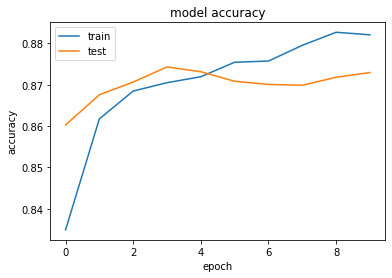

6513/6513 [==============================] - 0s 36us/step


[0.2789040777379578, 0.8739444017410278]

In [53]:
# Selecting model 2 to regularize by adding dropout layer
model = Sequential()
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, validation_split = 0.2 ,epochs=10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.evaluate(X_test, y_test, batch_size=16)

Train on 20838 samples, validate on 5210 samples
Epoch 1/10
20838/20838 [==============================] - 1s 67us/step - loss: 13.2669 - accuracy: 0.7523 - val_loss: 0.9189 - val_accuracy: 0.7572
Epoch 2/10
20838/20838 [==============================] - 1s 56us/step - loss: 0.9166 - accuracy: 0.7598 - val_loss: 0.9165 - val_accuracy: 0.7572
Epoch 3/10
20838/20838 [==============================] - 1s 52us/step - loss: 0.9145 - accuracy: 0.7598 - val_loss: 0.9168 - val_accuracy: 0.7572
Epoch 4/10
20838/20838 [==============================] - 1s 54us/step - loss: 0.9131 - accuracy: 0.7598 - val_loss: 0.9127 - val_accuracy: 0.7572
Epoch 5/10
20838/20838 [==============================] - 1s 52us/step - loss: 0.9107 - accuracy: 0.7598 - val_loss: 0.9090 - val_accuracy: 0.7572
Epoch 6/10
20838/20838 [==============================] - 1s 52us/step - loss: 0.9090 - accuracy: 0.7598 - val_loss: 0.9097 - val_accuracy: 0.7572
Epoch 7/10
20838/20838 [==============================] - 1s 55us/st

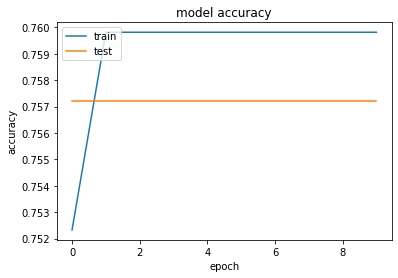

6513/6513 [==============================] - 0s 43us/step


[0.9018812501611714, 0.758790135383606]

In [56]:
# Selecting model 3 to regularize by using Elastic Net
from tensorflow import keras 

model = Sequential()
model.add(Dense(64, activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1 = 0.1, l2 = 0.01)))
model.add(Dense(32, activation = 'relu',kernel_regularizer=keras.regularizers.l1_l2(l1 = 0.1, l2 = 0.01)))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, validation_split = 0.2 ,epochs=10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.evaluate(X_test, y_test, batch_size=16)

### Fill in your part 5 conclusions here



Regularization with Elastic Net (L1 & L2) helps with model performance, as seen by the above graphs for Model 2. It stablizes model accuracy and reduces overfitting. Regularization with Dropout layer does not seem to improve performance much, as seen on Model 1